<a href="https://colab.research.google.com/github/73hr4774/ARIMA-Model/blob/main/Arima_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

**Dataset Loading**

In [ ]:
data=pd.read_csv('temperature-1.csv')
data.head()

,Unnamed: 0,Datetime,Hourly_Temp
0,0,04-01-2022 00:00,20.867
1,1,04-01-2022 01:00,21.000
2,2,04-01-2022 02:00,20.867
3,3,04-01-2022 03:00,20.650
4,4,04-01-2022 04:00,20.400


# **Data Preprocessing**

In [ ]:
data['Datetime'] = pd.to_datetime(data['Datetime'], format='%d-%m-%Y %H:%M')

In [ ]:
data.set_index('Datetime',inplace=True)

In [ ]:
data = data.drop('Unnamed: 0', axis=1)

# **Data Visualization**

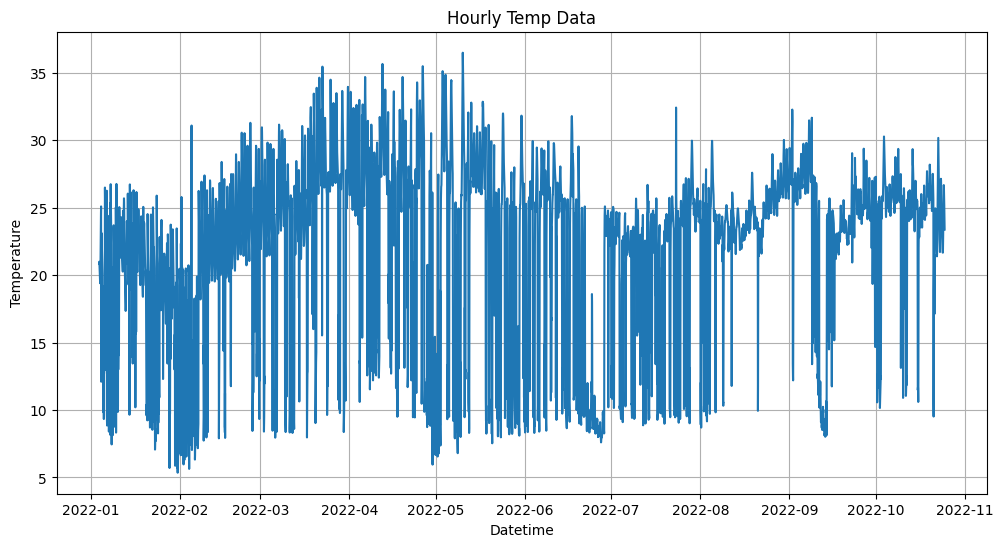

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(data['Hourly_Temp'])
plt.title('Hourly Temp Data')
plt.xlabel('Datetime')
plt.ylabel('Temperature')
plt.grid(True)
plt.show()

# **Stationarity**

In [ ]:
def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    return dfoutput

In [ ]:
result=test_stationarity(data['Hourly_Temp'])
print("Augmented Dickey-Fuller Test:")
print(result)

Augmented Dickey-Fuller Test:
Test Statistic                -9.396891e+00
p-value                        6.338903e-16
#Lags Used                     2.500000e+01
Number of Observations Used    7.030000e+03
Critical Value (1%)           -3.431281e+00
Critical Value (5%)           -2.861951e+00
Critical Value (10%)          -2.566989e+00
dtype: float64


# **Differencing**

In [ ]:
data['Temp_Diff'] = data['Hourly_Temp'] - data['Hourly_Temp'].shift(1)
data.dropna(inplace=True)

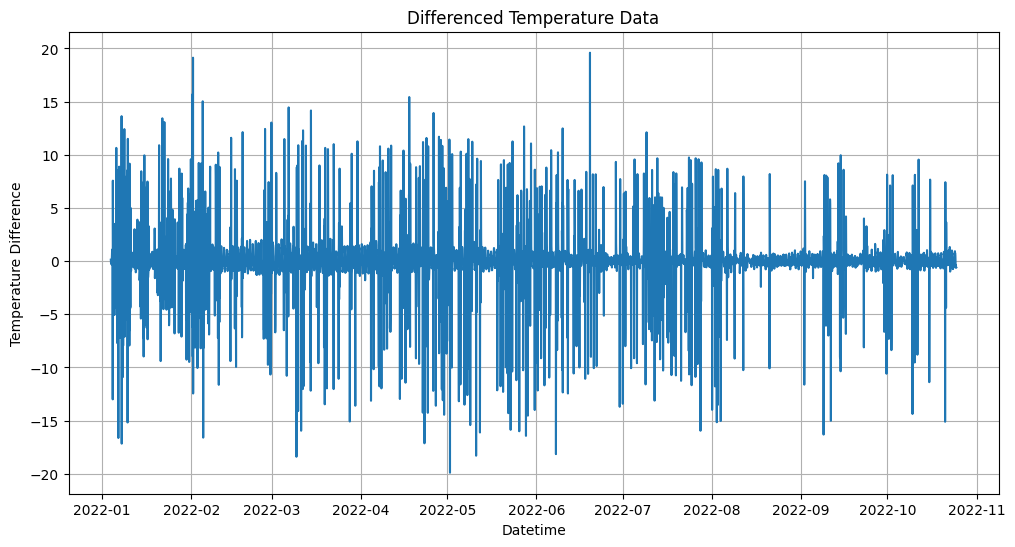

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data['Temp_Diff'])
plt.title('Differenced Temperature Data')
plt.xlabel('Datetime')
plt.ylabel('Temperature Difference')
plt.grid(True)
plt.show()

 **Stationarity of Differenced Data**

In [ ]:
result=test_stationarity(data['Temp_Diff'])
print("Augmented Dickey-Fuller Test:")
print(result)

Augmented Dickey-Fuller Test:
Test Statistic                  -20.546080
p-value                           0.000000
#Lags Used                       35.000000
Number of Observations Used    7019.000000
Critical Value (1%)              -3.431282
Critical Value (5%)              -2.861952
Critical Value (10%)             -2.566989
dtype: float64


# **Sarima Model**

In [ ]:
model=SARIMAX(data['Hourly_Temp'],order=(1,1,1),seasonal_order=(1,1,1,24))
result=model.fit(disp=False)

In [ ]:
result.fittedvalues

,0
Datetime,
2022-01-04 01:00:00,0.000000
2022-01-04 02:00:00,21.000010
2022-01-04 03:00:00,20.866999
2022-01-04 04:00:00,20.650000
2022-01-04 05:00:00,20.400000
...,...
2022-10-24 19:00:00,26.430356
2022-10-24 20:00:00,25.682744
2022-10-24 21:00:00,25.636873


In [ ]:
result.aic

34130.62281169135

In [ ]:
result.bic

34164.91252161537

In [ ]:
result.resid

,0
Datetime,
2022-01-04 01:00:00,21.000000
2022-01-04 02:00:00,-0.133010
2022-01-04 03:00:00,-0.216999
2022-01-04 04:00:00,-0.250000
2022-01-04 05:00:00,-0.300000
...,...
2022-10-24 19:00:00,-0.863356
2022-10-24 20:00:00,-0.499744
2022-10-24 21:00:00,-1.036873


**Forecasting**

In [ ]:
forecast_steps=24
forecast=result.get_forecast(steps=forecast_steps)

**Data range for Forecasting**

In [ ]:
date_range = pd.date_range(start=data.index[-1], periods=forecast_steps + 1, freq='H')

**Forecasted values and Confidence Interval**

In [ ]:
forecast_values=forecast.predicted_mean
forecast_conf_int=forecast.conf_int()

# **Forecast Dataframe**

In [ ]:
forecast_df=pd.DataFrame({'Forecast':forecast_values,'Lower_CI':forecast_conf_int.iloc[:,0],'Upper_CI':forecast_conf_int.iloc[:,1]},index=date_range[1:])

In [ ]:
forecast_df.head()

,Forecast,Lower_CI,Upper_CI
2022-10-25 00:00:00,23.352778,18.000924,28.704631
2022-10-25 01:00:00,23.050825,15.215395,30.886255
2022-10-25 02:00:00,21.575437,11.897747,31.253127
2022-10-25 03:00:00,21.395752,10.171783,32.619721
2022-10-25 04:00:00,21.940356,9.358989,34.521724


# **Plotting of Original Data and the Forecast**

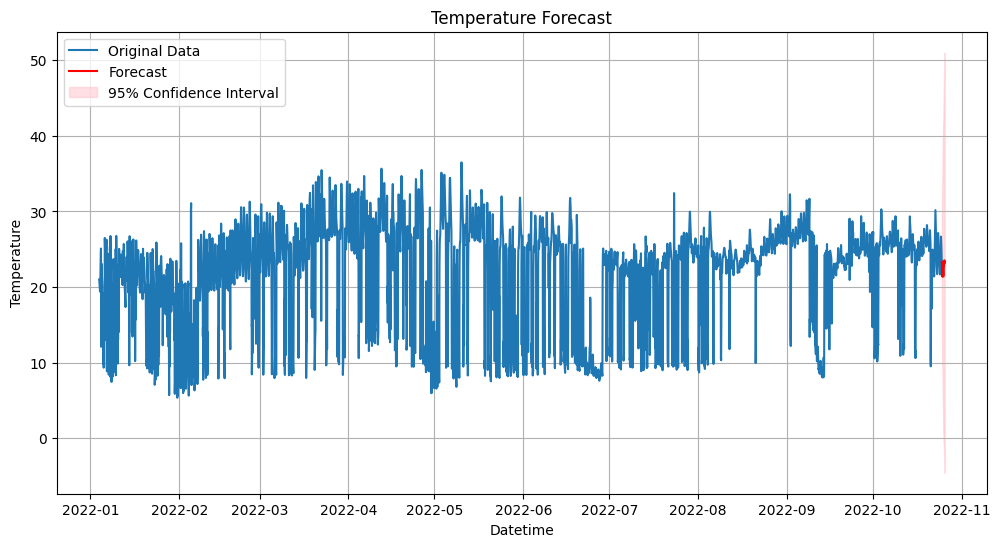

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data['Hourly_Temp'], label='Original Data')
plt.plot(forecast_df['Forecast'], label='Forecast', color='red')
plt.fill_between(forecast_df.index, forecast_df['Lower_CI'], forecast_df['Upper_CI'], color='pink', alpha=0.5, label='95% Confidence Interval')
plt.title('Temperature Forecast')
plt.xlabel('Datetime')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()